# Kaggle competition Machine learning
by 
Sidney Gharib - 2145565,
Elizabteh Michaud - 2073093 and
Alexis Nicolas - 2143258

## Imports

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.utils import gen_batches
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data pre-processing

In [172]:
def get_training_data():
    return  pd.read_csv('../data/train.csv'), pd.read_csv('../data/labels.csv')

def get_testing_data():
    return pd.read_csv('../data/test.csv')

def feature_encoding(X):
    """
    One-hot encode the 'features'.
    Input: X: features (pd.DataFrame)
    Output: X: features_encoded (pd.DataFrame)
    """
    non_numerical_columns_names = X.select_dtypes(exclude=['number']).columns
    le = LabelEncoder()
    for column in non_numerical_columns_names:
        # Only encore the columns that are not numerical 
        X[column] = le.fit_transform(X[column])

    return X

def normalize_features(X_train, X_validation, X_test, Is_Standard_scaler = True):
    """
    Take the input data and normalize the features.
    Input: X_train: features for train,  X_test: features for test (pd.DataFrame)
    Output: X_train_scaled, X_test_scaled (pd.DataFrame) the same shape of X_train and X_test
    """
    if Is_Standard_scaler: scaler = StandardScaler()
    else: scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_validation_scaled, X_test_scaled

In [173]:
X, y = get_training_data()
X_testing = get_testing_data()
#Unnamed: 0 is the Id of the row, we can drop it
X = X.drop('Unnamed: 0', axis=1 )

x_testing_id = X_testing['Unnamed: 0']
X_testing = X_testing.drop('Unnamed: 0', axis=1 )
# Unnamed: 0 is the Id of the row, we can drop it
y = y.drop(columns=['Unnamed: 0'])  # If the first column is labeled as 'Unnamed: 0'
# This variable is only used for the final test, to prevent long grid search from running
isFinal = True


## Data exploration

In [174]:
print('Number of elements :', len(X))
print('Number of features :', len(X.columns))

Number of elements : 202944
Number of features : 28


In [175]:
print('len(y):', len(y))

len(y): 202944


In [176]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202944 entries, 0 to 202943
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                202944 non-null  int64  
 1   HighChol              202944 non-null  int64  
 2   CholCheck             202944 non-null  int64  
 3   BMI                   202944 non-null  float64
 4   Smoker                202944 non-null  int64  
 5   Stroke                202944 non-null  int64  
 6   HeartDiseaseorAttack  202944 non-null  int64  
 7   PhysActivity          202944 non-null  int64  
 8   Fruits                202944 non-null  int64  
 9   Veggies               202944 non-null  int64  
 10  HvyAlcoholConsump     202944 non-null  int64  
 11  AnyHealthcare         202944 non-null  int64  
 12  NoDocbcCost           202944 non-null  int64  
 13  GenHlth               202944 non-null  int64  
 14  MentHlth              202944 non-null  float64
 15  

In [177]:
X.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
BMI_Category            0
Healthy_Diet            0
Mental_Health_Risk      0
Heart_Disease_Risk      0
Age_Group               0
Education_Level         0
Income_Group            0
dtype: int64

In [178]:
unique_values = {}
for col in X.columns:
    unique_values[col] = X[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
HighBP,2
HighChol,2
CholCheck,2
BMI,182669
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2
Veggies,2


In [179]:
bmi_category_order = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
age_group_order = ['Young']
education_level_order = ['No High School', 'High School Graduate', 'Some College']
income_group_order = ['Low Income', 'Middle Income', 'High Income']

def ordinal_feature_encoding(x):
  non_numerical_col = x.select_dtypes(exclude=['number']).columns
  ordinal_encoder = OrdinalEncoder(categories=[bmi_category_order, age_group_order, education_level_order, income_group_order])
  x[non_numerical_col] = ordinal_encoder.fit_transform(x[non_numerical_col])

  return x

X = ordinal_feature_encoding(X)


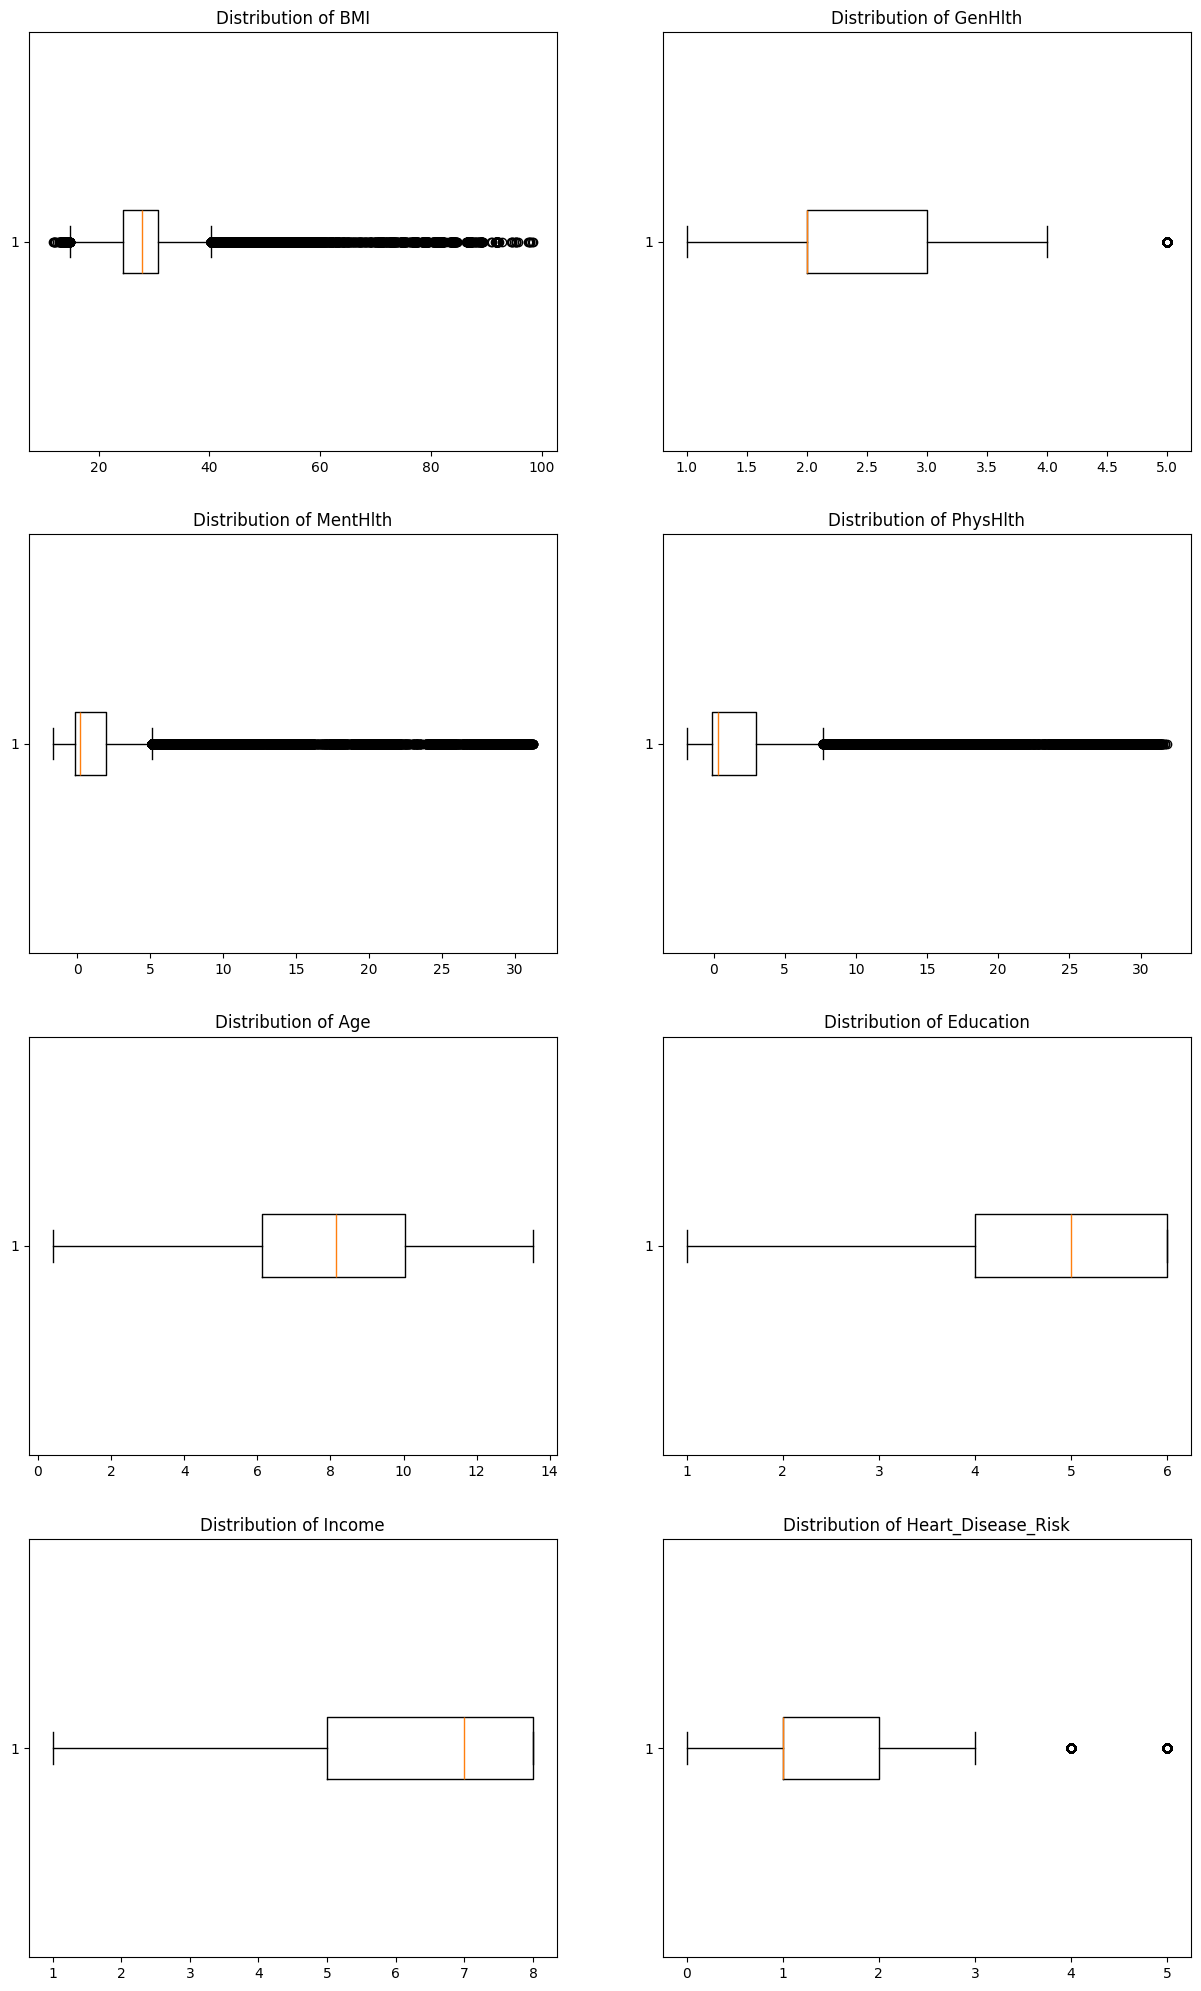

In [180]:
plt.figure(figsize = (15,25))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income', 'Heart_Disease_Risk']):
    plt.subplot(4,2,i+1)
    plt.title('Distribution of '+col)
    plt.boxplot(x = col, data = X, vert=False)
plt.show()

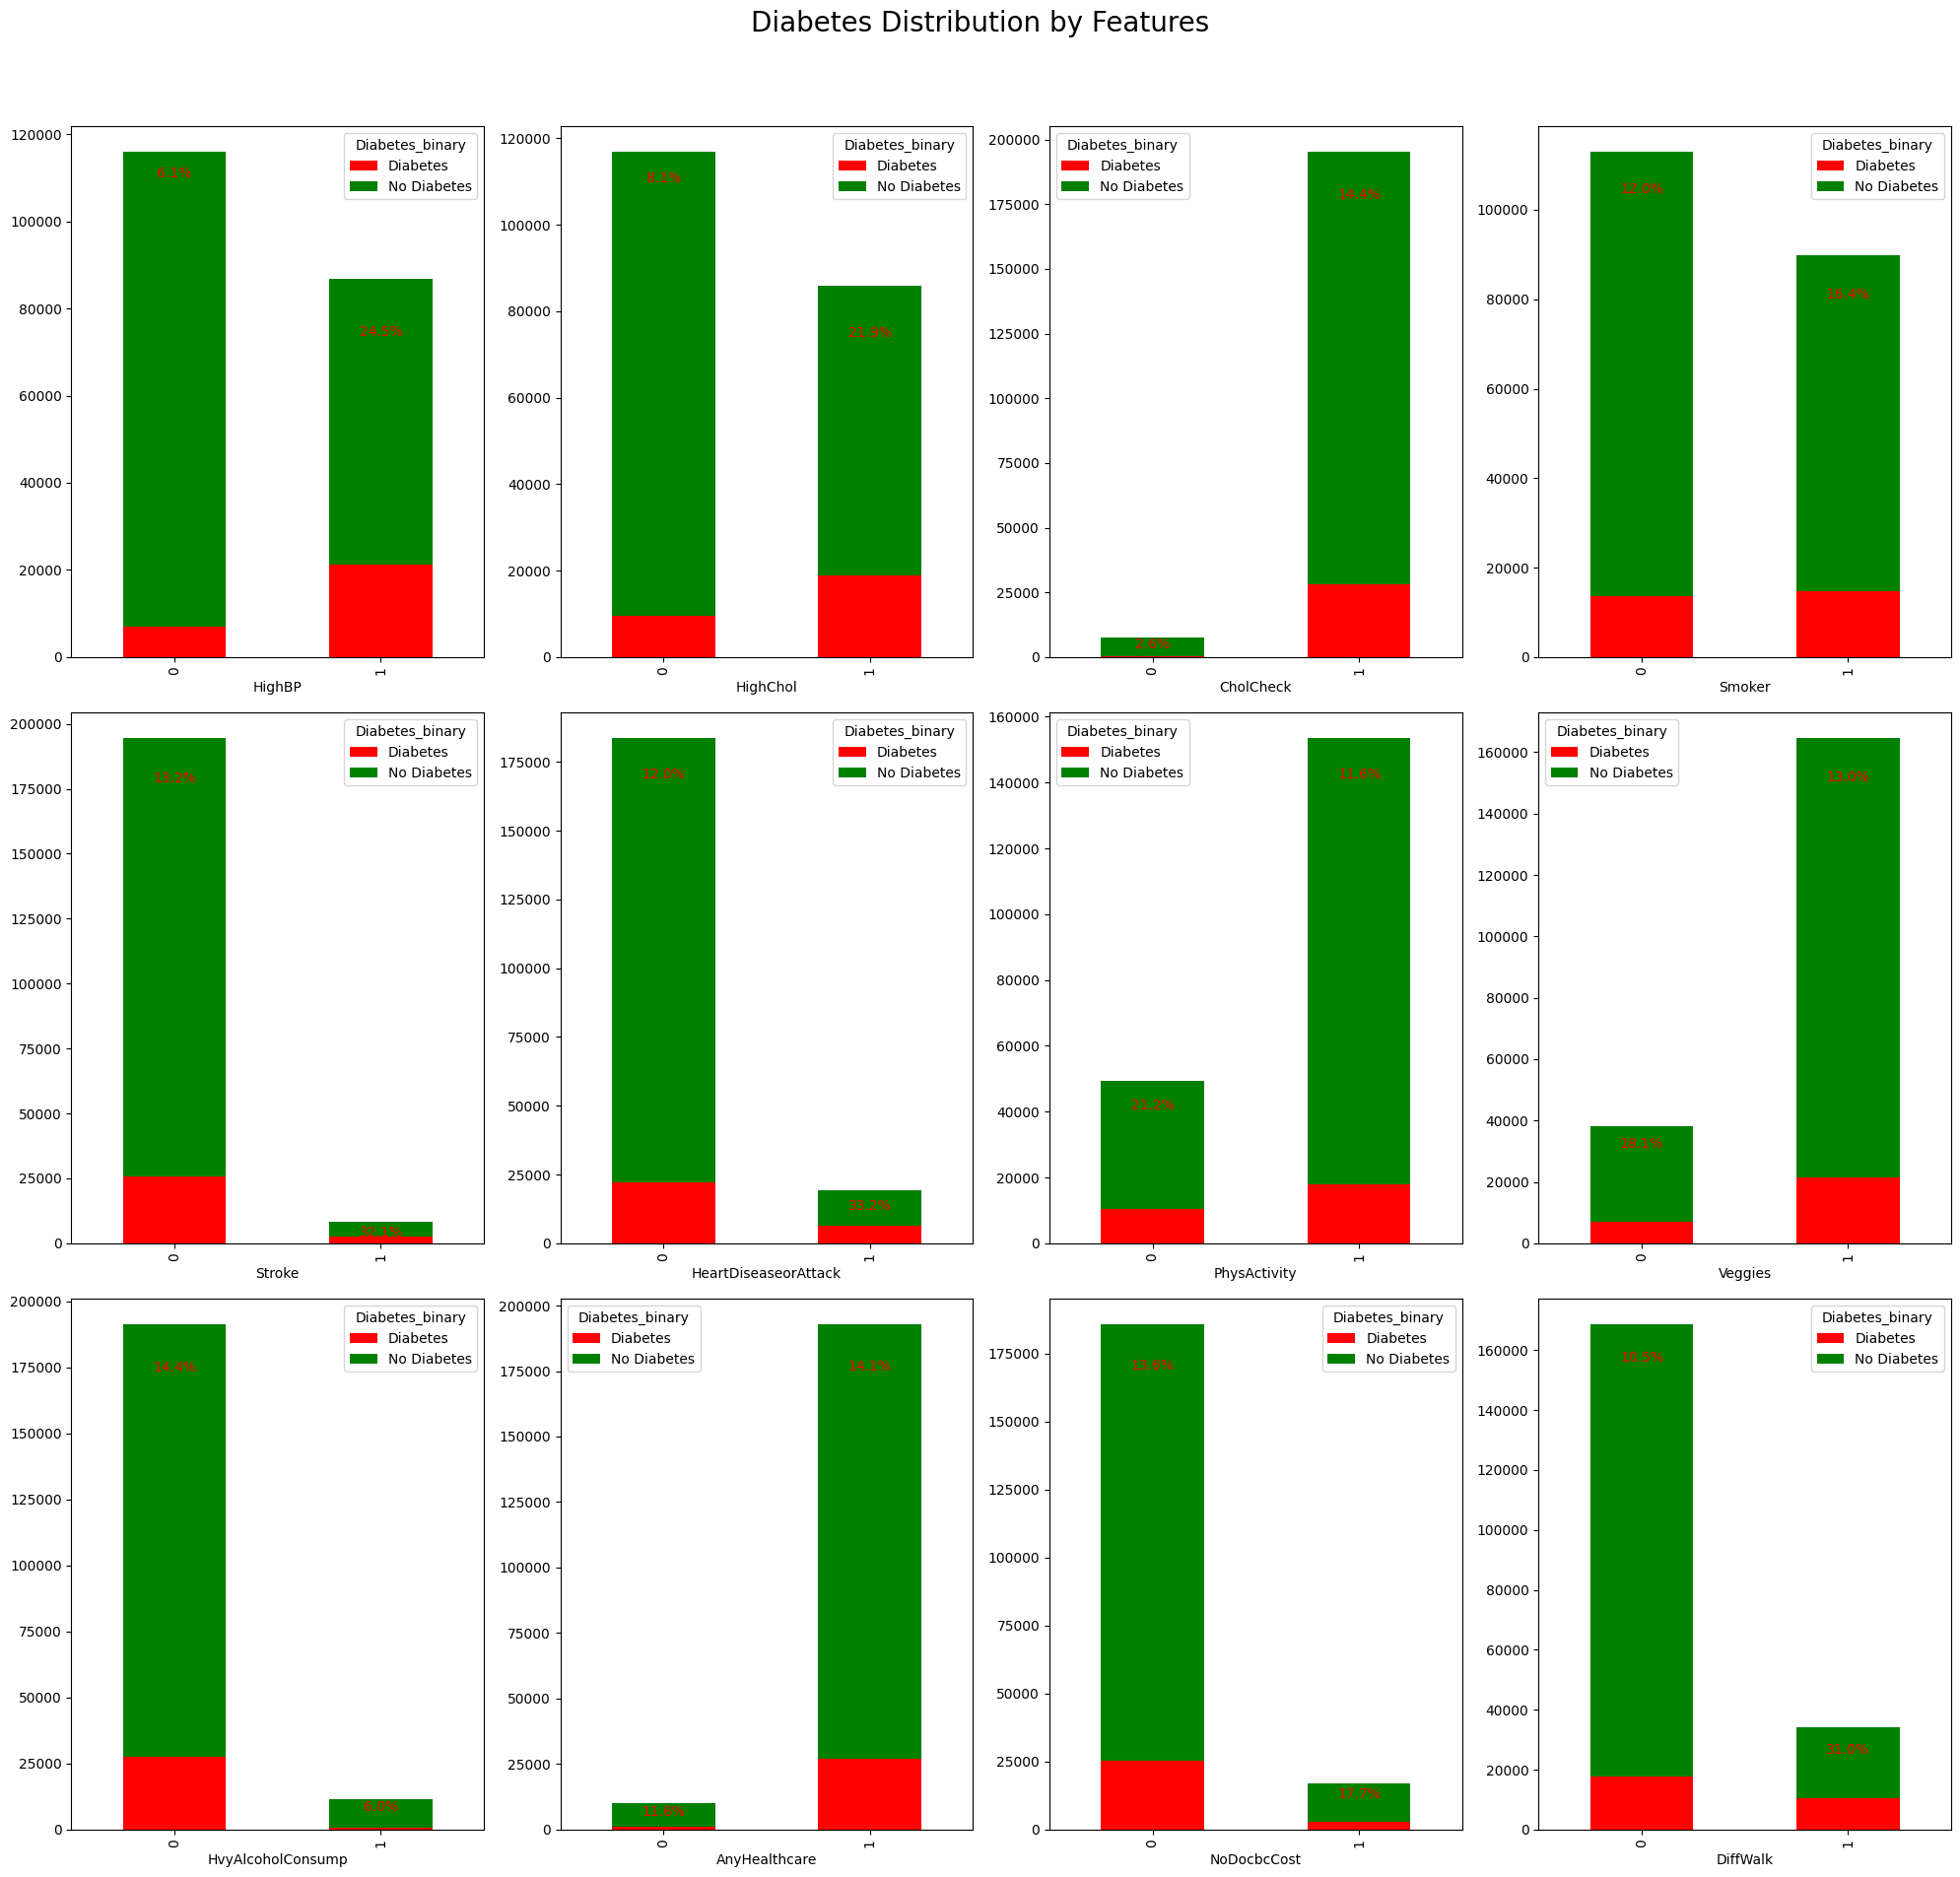

In [181]:
# The following graphs are inspired by https://www.kaggle.com/code/khizarkhan/diabetes-prediction
cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

def create_plot_pivot(data, x_column):
    """Create a pivot table for satisfaction versus another rating for easy plotting."""
    # Merge `X` and `y` to ensure access to 'Diabetes_binary' column for grouping
    data_with_target = data.copy()
    data_with_target['Diabetes_binary'] = y['Diabetes_binary']
    data_with_target['Diabetes_binary'] = data_with_target['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})
    
    _df_plot = data_with_target.groupby([x_column, 'Diabetes_binary']).size() \
                   .reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()
c = len(cols)
plt.suptitle('Diabetes Distribution by Features', fontsize=20)

# Custom colors for the plot
custom_colors = {'No Diabetes': 'green', 'Diabetes': 'red'}

# Plotting each column in cols
for i in range(c):
    plot_data = create_plot_pivot(X, cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=[custom_colors[val] for val in plot_data.columns])
    axe[i].set_xlabel(cols[i])
    
    # Adding percentage labels for the "Diabetes" (red) part of each bar
    for j, (index, row) in enumerate(plot_data.iterrows()):
        total = row['No Diabetes'] + row['Diabetes']  # Sum of "No Diabetes" and "Diabetes" counts
        if total > 0:
            diabetes_percentage = (row['Diabetes'] / total) * 100  # Calculate percentage for Diabetes
            axe[i].text(j, row['No Diabetes'] + row['Diabetes'] / 2, 
                        f"{diabetes_percentage:.1f}%", color="red", ha="center", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: title={'center': 'Correlation with Diabetes_binary'}>

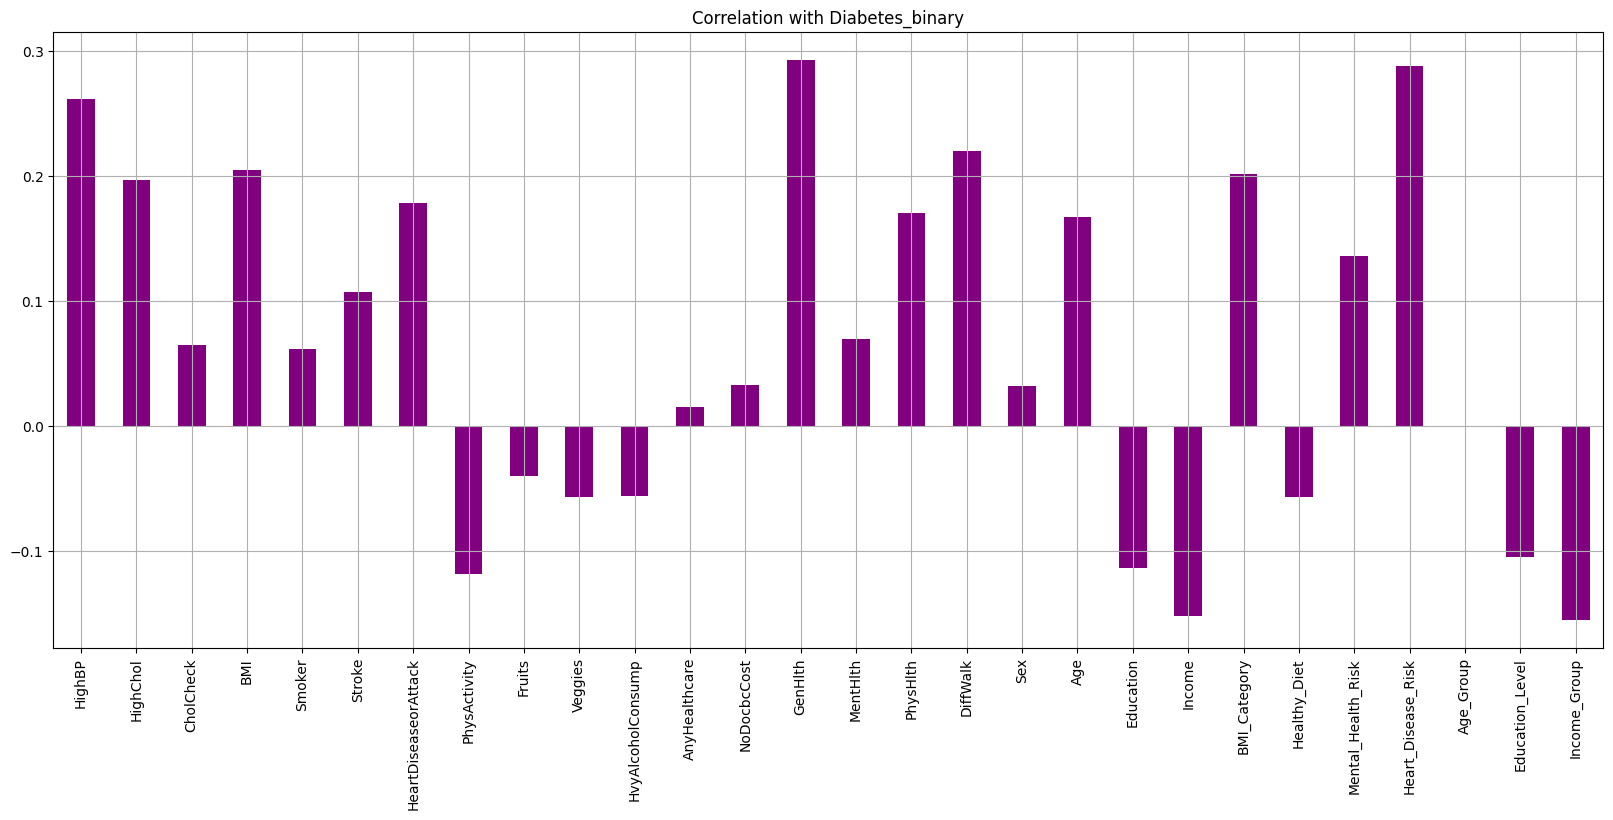

In [182]:
# Filter numeric columns only from X
X_numeric = X.select_dtypes(include=[np.number])

# Compute correlation with y
X_numeric.corrwith(y['Diabetes_binary']).plot(kind='bar', grid=True, figsize=(20, 8),
                                              title="Correlation with Diabetes_binary", color="Purple")


In [183]:


binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Healthy_Diet', 'Mental_Health_Risk']
continuous_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
ordinal_features = ['GenHlth', 'Education', 'Income', 'BMI_Category', 'Heart_Disease_Risk', 'Age_Group', 'Education_Level', 'Income_Group']

def get_mutual_info(x_train, features, y_train, discrete=None):
    if discrete == None:
        mi_scores = mutual_info_classif(x_train[features], y_train['Diabetes_binary'])
    else:
        mi_scores = mutual_info_classif(x_train[features], y_train['Diabetes_binary'], discrete_features=discrete)
    
    return pd.DataFrame({'Features': features, 'Mutual Information Scores': mi_scores}).sort_values(by='Mutual Information Scores', ascending=False)

print(get_mutual_info(X, binary_features, y, True))
print()
print(get_mutual_info(X, continuous_features, y))
print()
print(get_mutual_info(X, ordinal_features, y, False))

                Features  Mutual Information Scores
0                 HighBP                   0.034746
12              DiffWalk                   0.020313
1               HighChol                   0.019329
5   HeartDiseaseorAttack                   0.012736
15    Mental_Health_Risk                   0.008292
6           PhysActivity                   0.006462
4                 Stroke                   0.004536
2              CholCheck                   0.002984
3                 Smoker                   0.001919
9      HvyAlcoholConsump                   0.001898
14          Healthy_Diet                   0.001592
8                Veggies                   0.001529
7                 Fruits                   0.000774
13                   Sex                   0.000507
11           NoDocbcCost                   0.000503
10         AnyHealthcare                   0.000132

   Features  Mutual Information Scores
0       BMI                   0.025521
3       Age                   0.01888

#### Gaussian distribution

In [184]:
def normal_probability_plot(data, col):
    """
    Generates a normal probability plot for the given data.
    
    Parameters:
        data (array-like): The data for which to generate the plot.
        
    Returns:
        None
    """
    # Generate a probability plot
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Normal Probability Plot for "+ col)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

### Gaussian probability plot

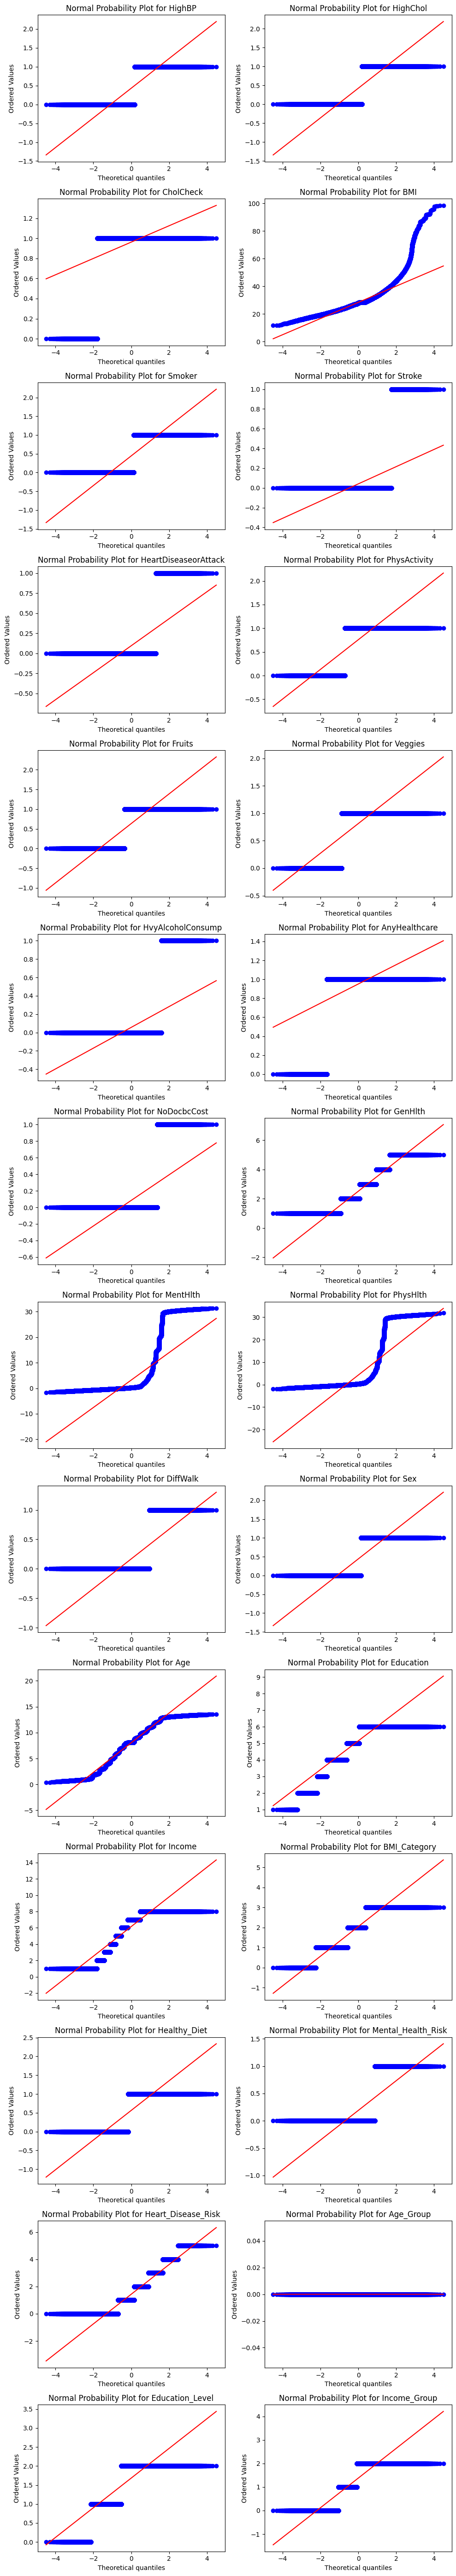

In [185]:
def normal_probability_plot(data, columns):
    """
    Generates normal probability plots for the given columns using matplotlib in a single figure.

    Parameters:
        data (DataFrame): The data containing the columns to plot.
        columns (list): List of column names to plot.

    Returns:
        None
    """
    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2  # Two columns per row

    fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4 * n_rows))
    axes = axes.flatten()  # Flatten to easily index axes

    for i, col in enumerate(columns):
        stats.probplot(data[col], dist="norm", plot=axes[i])
        axes[i].set_title(f'Normal Probability Plot for {col}')

    plt.tight_layout()
    plt.show()

normal_probability_plot(X, X.columns)


### Correlation matrix

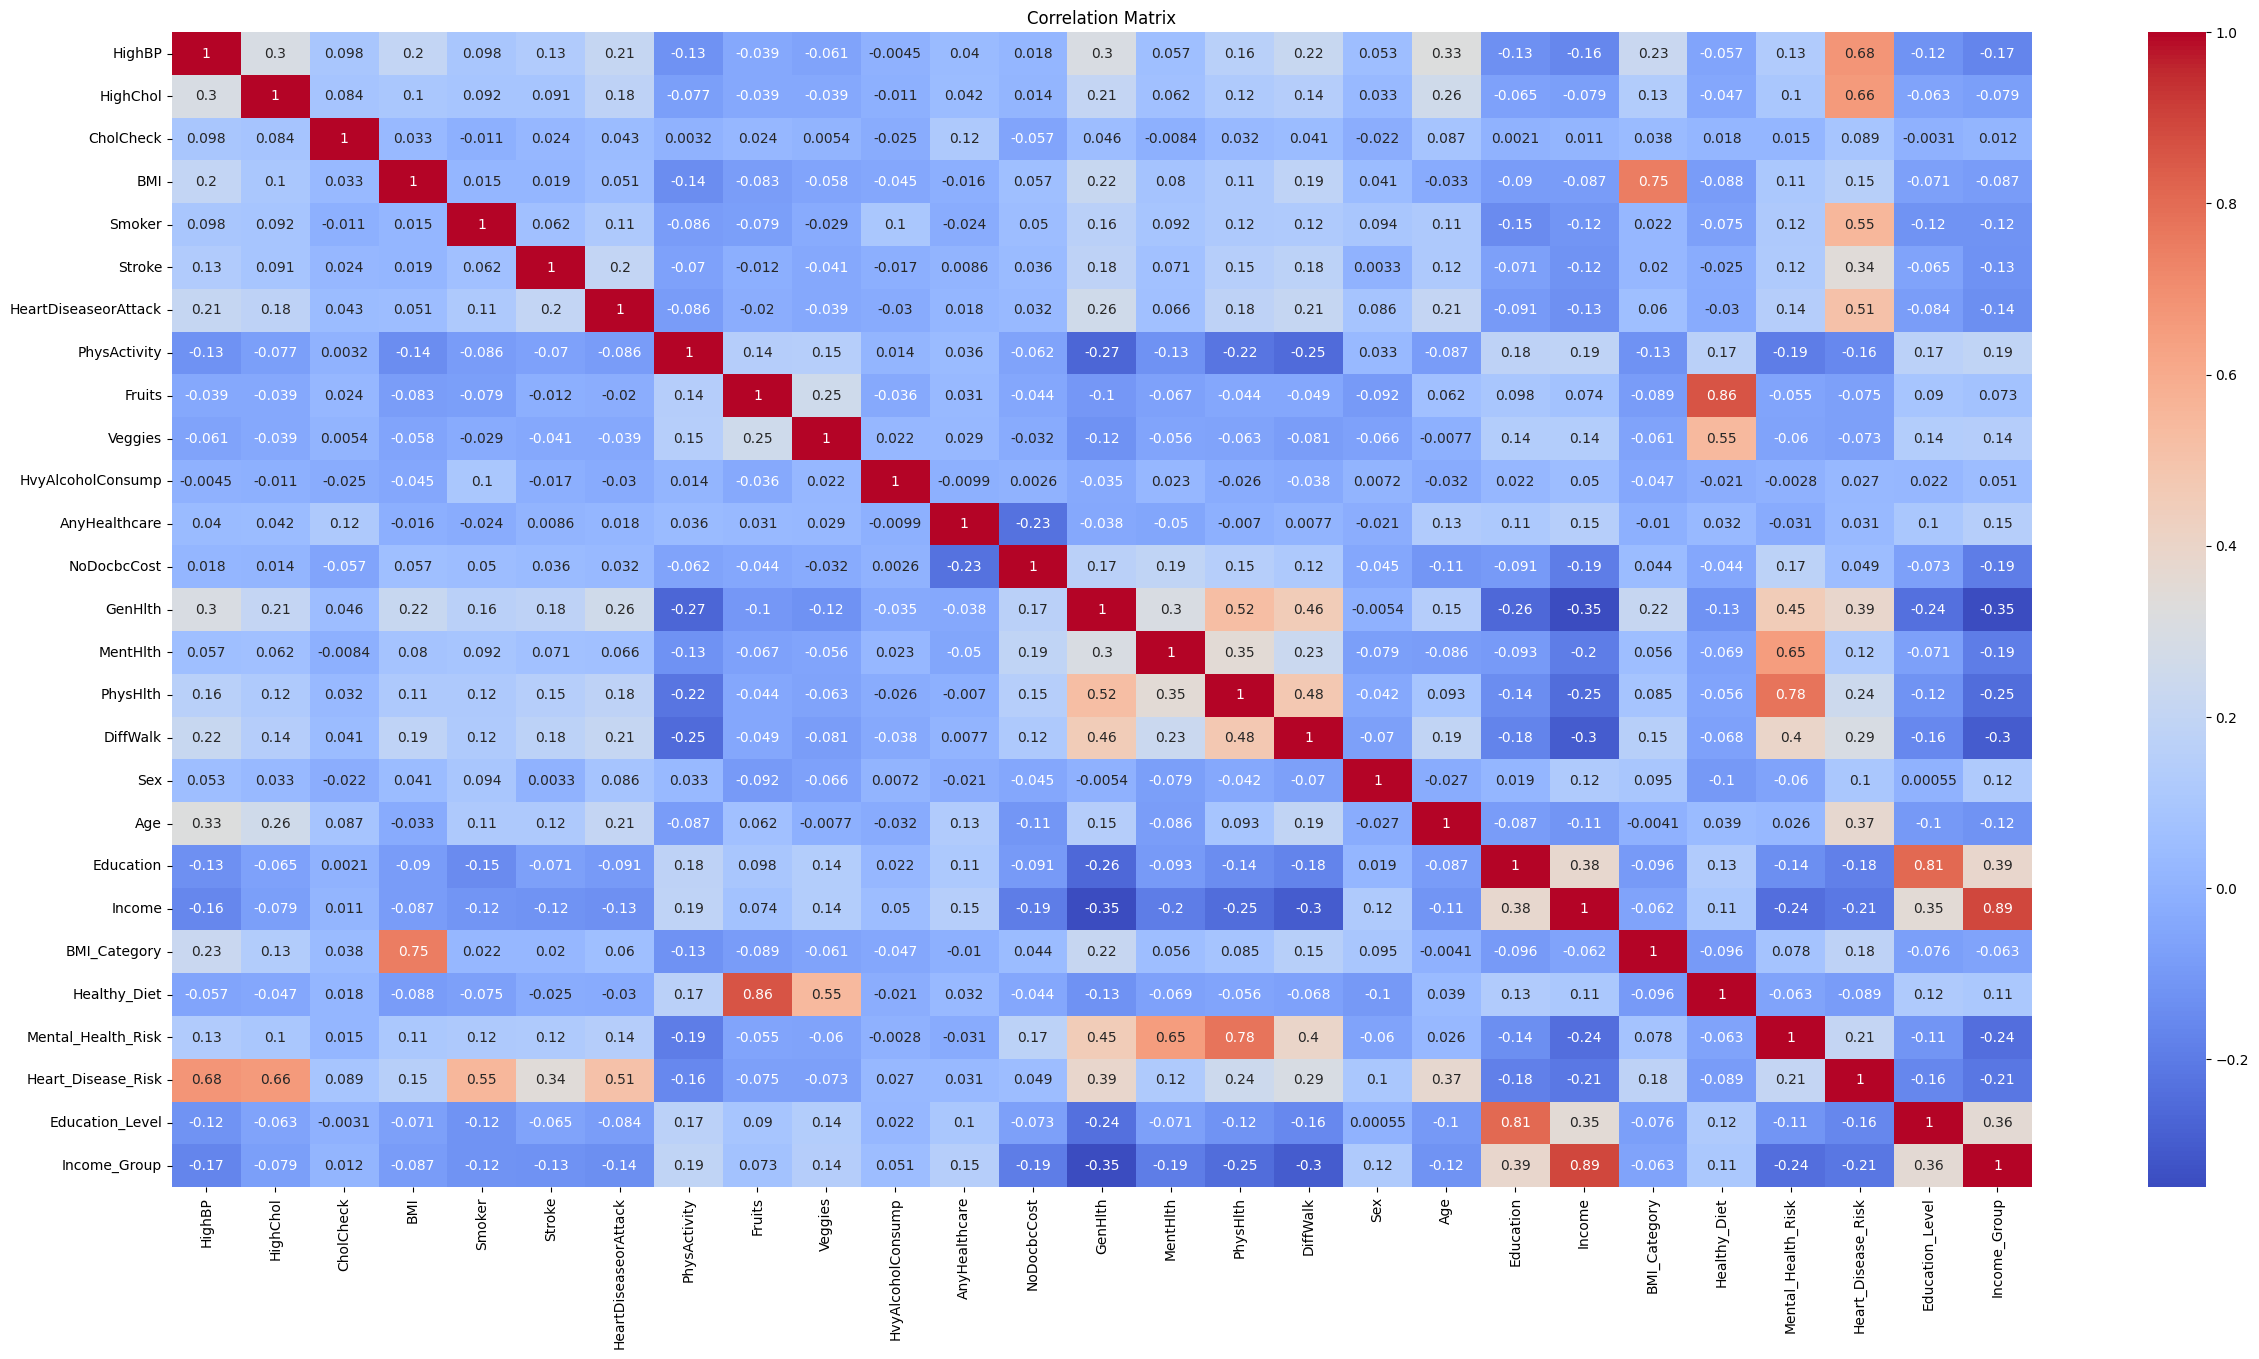

In [186]:
#Correlation matrix
X = X.drop(columns=['Age_Group'])
corr = X.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Training functions

### Process the data and Split validation set and train set

In [187]:
def data_splits(X, y):
    """
    Split the 'features' and 'labels' data into training and testing sets.
    Input(s): X: features (pd.DataFrame), y: labels (pd.DataFrame)
    Output(s): X_train, X_test, y_train, y_test
    """
    # Split the data into training and testing sets
    # I added the stratify=y to make sure that the distribution of the labels in the train and test sets are the same
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, shuffle=True, random_state=0, stratify=y)

    return X_train, X_test, y_train, y_test

In [188]:

is_equal_classes = False
# Look for multicollinearity between the features and remove the features that are unnecessary
# we already know the age so age_group is not needed
X, y = get_training_data()
X_testing = get_testing_data()
X = X.drop('Unnamed: 0', axis=1 )
x_testing_id = X_testing['Unnamed: 0']
X_testing = X_testing.drop('Unnamed: 0', axis=1 )
# Unnamed: 0 is the Id of the row, we can drop it
y = y.drop(columns=['Unnamed: 0'])

columnsToDrop = ['Age_Group', 'MentHlth', 'HvyAlcoholConsump', 'NoDocbcCost', 'Smoker', 'Fruits', 'Veggies', 'Mental_Health_Risk' , 'AnyHealthcare' ] #'Heart_Disease_Risk', 'Income', 'Education'

X = X.drop(columns=columnsToDrop)
X = feature_encoding(X)

X_testing = X_testing.drop(columns=columnsToDrop)
X_testing = feature_encoding(X_testing)

# Basic splits of the data
X_train, X_validation, y_train, y_validation =  data_splits(X, y) #   split data
is_equal_classes = False
X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data

In [189]:

def predict_in_batches(cls, X, batch_size=100):
    """
    Make predictions for the input data in batches.
    
    Parameters:
        cls (object): The trained classifier model.
        X (array-like): The input data to make predictions for.
        batch_size (int): The size of each batch.
        
    Returns:
        array-like: The predictions for the input data.
    """
    predictions = []
    
    # Generate batches and make predictions for each batch
    for batch in gen_batches(len(X), batch_size):
        batch_predictions = cls.predict(X[batch])
        predictions.append(batch_predictions)
    
    # Concatenate all batch predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [190]:
def perform_grid_search(model, X_train_scaled, y_train, params):
    print("Performing grid search for ", model)
    if not isFinal:
        # Define the cross-validation strategy
        strat_kfold = StratifiedKFold(n_splits=10) # TODO

        # Grid search for the model 
        #"f1_macro": Calculates F1-score per class and takes the average, treating all classes equally.
        #"f1_weighted": Calculates F1-score per class and takes a weighted average, considering class imbalance.
        grid_search = GridSearchCV(model, params, scoring='f1', cv=strat_kfold, n_jobs=10) # n_jobs=10 uses 10 parallel processes. Speeds up the process 


        if isinstance(model, RandomForestClassifier) or isinstance(model, SVC):
            grid_search.fit(X_train_scaled, y_train.values.ravel())
        else:
            grid_search.fit(X_train, y_train)
        best_param = grid_search.best_params_
        best_score = grid_search.best_score_ 
        print("Best parameters are:", best_param)
        print("Best score is:", best_score)

        # Return the fitted grid search objects
        return grid_search, best_param, best_score
    else:
        print("Skipping grid search for TA evaluation")

In [191]:
def model_training(model, X_train_scaled, y_train, X_validation_scaled, y_validation):
    model.fit(X_train_scaled, y_train)
    y_validation_pred = model.predict(X_validation_scaled)
    validation_f1 = f1_score(y_validation, y_validation_pred)
    print("Validation f1 score:", validation_f1)
    print(classification_report(y_validation, y_validation_pred))

In [192]:
def classification_summary(y_train, y_train_pred, y_validation, y_validation_pred):
    train_f1 = f1_score(y_train, y_train_pred) 
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Train f1 score:", train_f1)

    print("Validation f1 score:", validation_f1)
    print("\nTraining Set Classification Report:")

    print(classification_report(y_train, y_train_pred))

    print("Training Set Confusion Matrix:")

    print(confusion_matrix(y_train, y_train_pred))

    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [193]:
def classification_summary_one( y_validation, y_validation_pred):
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Validation f1 score:", validation_f1)
    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [194]:
def kaggle_submission(model, X_testing_scaled, x_testing_id):
    y_pred = model.predict(X_testing_scaled)
    y_pred = pd.DataFrame({
        'index': x_testing_id , 
        'Diabetes_binary': y_pred,
    })

    # Save the predictions to a CSV file
    y_pred.to_csv(f'./{model}_y_pred.csv', index=False)

In [195]:
def submission_pred(model, X_testing_scaled):
    return model.predict(X_testing_scaled)


def submission_proba(model, X_testing_scaled):
    return model.predict_proba(X_testing_scaled)[:, 1]

## Models

### Random Forest

In [196]:
############### TESTING ####################
cls_randomforest = RandomForestClassifier(class_weight='balanced', 
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                          min_samples_leaf=20, n_estimators=500)

param_grid_random_forest = {
    'n_estimators': [10, 200, 300, 400, 500, 1000, 5000],
    'max_depth': [20, 30],
    'bootstrap': [True, False],
}
if not isFinal:
    perform_grid_search(cls_randomforest, X_train_scaled, y_train, params= param_grid_random_forest)




In [197]:
if is_equal_classes:
    print('Equal classes')
    cls_randomforest = RandomForestClassifier(class_weight='balanced',
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                           n_estimators=1000) #min_samples_leaf=20
else:
    cls_randomforest = RandomForestClassifier( class_weight={0: 1, 1: 3}, # class_weight='balanced',
                                            random_state=0, 
                                            max_depth=20, 
                                            max_leaf_nodes=200, 
                                            n_estimators=1000) #min_samples_leaf=20

model_training(cls_randomforest, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Validation f1 score: 0.461889548151529
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     17460
           1       0.41      0.54      0.46      2835

    accuracy                           0.83     20295
   macro avg       0.66      0.70      0.68     20295
weighted avg       0.85      0.83      0.84     20295



### Random Forest with PCA

In [198]:
if not isFinal:
    pca = PCA(n_components=12)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    cls_randomforest_pca = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=20, max_leaf_nodes=200, n_estimators=1000)
    model_training(cls_randomforest_pca, X_train_pca, y_train, pca.transform(X_validation_scaled), y_validation)

### Decision Tree

In [199]:
cls_decision_tree = DecisionTreeClassifier(max_depth=5)


param_grid_decision_tree = {
    'criterion': ['gini','entropy'],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [2, 3, 10],
    'max_leaf_nodes': [5, 10, 50]
}

perform_grid_search(cls_decision_tree, X_train_scaled, y_train, params=param_grid_decision_tree)


Performing grid search for  DecisionTreeClassifier(max_depth=5)
Skipping grid search for TA evaluation


In [200]:
cls_decision_tree = DecisionTreeClassifier(criterion='gini', class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
model_training(cls_decision_tree, X_train_scaled, y_train, X_validation_scaled, y_validation)

Validation f1 score: 0.4251925192519252
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     17460
           1       0.35      0.55      0.43      2835

    accuracy                           0.79     20295
   macro avg       0.63      0.69      0.65     20295
weighted avg       0.84      0.79      0.81     20295



### Decision Tree with Bagging

In [201]:
cls_decision_tree = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='gini', max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
bagging_model = BaggingClassifier(estimator=cls_decision_tree, n_estimators=50, random_state=42)
model_training(bagging_model, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation f1 score: 0.4362767070073211
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     17460
           1       0.38      0.51      0.44      2835

    accuracy                           0.81     20295
   macro avg       0.65      0.69      0.66     20295
weighted avg       0.84      0.81      0.83     20295



### Decision Tree with Adaboosting

In [202]:
# Set up a decision stump as the weak learner
base_estimator = DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3}, criterion='gini')  # Decision stump class_weight='balanced'

# Create an AdaBoost classifier using the decision tree as the base estimator
ada_boost = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Assuming `model_training` is a function that trains and evaluates the model
model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation f1 score: 0.46190055898793764
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     17460
           1       0.40      0.55      0.46      2835

    accuracy                           0.82     20295
   macro avg       0.66      0.71      0.68     20295
weighted avg       0.85      0.82      0.83     20295



### Logistic Regression

In [203]:
cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=5)
param_grid_logistic = {
    'max_iter':[1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.5, 1, 10],
}
if not isFinal:
    perform_grid_search(cls_logistic, X_train_scaled, y_train, param_grid_logistic)

In [204]:
### Use best parameters to train the model
if is_equal_classes:
    print('Equal classes')
    cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=1, tol=1e-3)
else:
    cls_logistic = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)
model_training(cls_logistic, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation f1 score: 0.4622074434070853
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     17460
           1       0.36      0.64      0.46      2835

    accuracy                           0.79     20295
   macro avg       0.65      0.73      0.67     20295
weighted avg       0.85      0.79      0.81     20295



### Logistic Regression with Adaboosting

In [205]:
# Initialize logistic regression as the base estimator
cls_logistic_regiression = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)

# Create an AdaBoost classifier using logistic regression as the base estimator
ada_boost = AdaBoostClassifier(estimator=cls_logistic_regiression, n_estimators=50, learning_rate=1.0, random_state=42)

model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation f1 score: 0.45926310326933056
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     17460
           1       0.36      0.62      0.46      2835

    accuracy                           0.79     20295
   macro avg       0.65      0.72      0.67     20295
weighted avg       0.85      0.79      0.82     20295



### XGBClassifier

In [206]:
# Initialize the XGBoost classifier
# Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
xgb_model = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss') # binary:hinge

# Define the parameter grid
param_grid = {
    'eval_metric': ['error', 'logloss'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 15]
}
perform_grid_search(xgb_model, X_train_scaled, y_train, param_grid)

Performing grid search for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Skipping grid search for TA evaluation


In [207]:
xgb_model = XGBClassifier(random_state=0, max_depth=10,  objective='binary:logistic', eval_metric='error', booster='gbtree', n_estimators=5000)
model_training(xgb_model, X_train_scaled, y_train, X_validation_scaled, y_validation)


Validation f1 score: 0.2945314272747901
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17460
           1       0.41      0.23      0.29      2835

    accuracy                           0.85     20295
   macro avg       0.65      0.59      0.60     20295
weighted avg       0.82      0.85      0.83     20295



### SVM

In [208]:
cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1)
param_grid_svm = {
    'kernel':['rbf', 'sigmoid'],
    'shrinking': [True],
    'C': [1, 10],
}
perform_grid_search(cls_svm, X_train_scaled, y_train, param_grid_svm)

Performing grid search for  SVC(C=1, class_weight='balanced', random_state=42)
Skipping grid search for TA evaluation


In [209]:
if not isFinal:
    cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1, shrinking=True)
    model_training(cls_svm, X_train_scaled, y_train, X_validation_scaled, y_validation)

### K-NN

In [210]:

param_grid_svm = {
    'weights':['distance', 'uniform', None],
    'leaf_size': [10, 30, 50],
}
cls_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
perform_grid_search(cls_knn, X_train_scaled, y_train, param_grid_svm)

Performing grid search for  KNeighborsClassifier()
Skipping grid search for TA evaluation


In [211]:
cls_knn = KNeighborsClassifier(n_neighbors=10,  weights='distance', algorithm='kd_tree', leaf_size= 10)
model_training(cls_knn, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Validation f1 score: 0.2543178973717146
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     17460
           1       0.44      0.18      0.25      2835

    accuracy                           0.85     20295
   macro avg       0.66      0.57      0.59     20295
weighted avg       0.82      0.85      0.83     20295



### MLP

In [212]:
cls_mlp = MLPClassifier( random_state=42)
param_grid_mlp = {
    'hidden_layer_sizes':[(100, 50), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400],
    'solver': ['adam', 'sgd'],
    'shuffle': [True, False],
}
perform_grid_search(cls_mlp, X_train_scaled, y_train, param_grid_mlp)

Performing grid search for  MLPClassifier(random_state=42)
Skipping grid search for TA evaluation


In [213]:
cls_mlp = MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50, 10, 1), activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', shuffle=True)
cls_mlp.fit(X_train_scaled, y_train)
y_validation_pred = cls_mlp.predict(X_validation_scaled)
classification_summary_one(y_validation, y_validation_pred)


c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation f1 score: 0.27728174603174605

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     17460
           1       0.47      0.20      0.28      2835

    accuracy                           0.86     20295
   macro avg       0.67      0.58      0.60     20295
weighted avg       0.82      0.86      0.83     20295

Validation Set Confusion Matrix:
[[16822   638]
 [ 2276   559]]


### Bagging

In [214]:
# Validation set predictions

pred_array = []
for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_validation_scaled)) 

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

Validation f1 score: 0.46134250413960004

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     17460
           1       0.36      0.64      0.46      2835

    accuracy                           0.79     20295
   macro avg       0.65      0.73      0.67     20295
weighted avg       0.85      0.79      0.81     20295

Validation Set Confusion Matrix:
[[14255  3205]
 [ 1024  1811]]


### Predictions for multiple models

In [215]:
# Testing set predictions

pred_array = []
for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_testing_Scaled))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

# Save the predictions to a CSV file
y_pred = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': pred_array[0],
})
if not isFinal:
    y_pred.to_csv('./y_pred.csv', index=False)

In [216]:
prob_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    prob_array.append(submission_proba(model, X_validation_scaled))

# Take most confident prediction
prob_array = np.array(prob_array)
for i in range(len(prob_array[0])):
    if sum([prob[i] for prob in prob_array]) >= 2.3: # best is either 1.3 or 1.4 considering 3 models
        prob_array[0][i] = 1
    else:
        prob_array[0][i] = 0
pred_array = prob_array[0].astype(int)
classification_summary_one(y_validation, pred_array)

Validation f1 score: 0.4417989417989418

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     17460
           1       0.42      0.47      0.44      2835

    accuracy                           0.83     20295
   macro avg       0.66      0.68      0.67     20295
weighted avg       0.84      0.83      0.84     20295

Validation Set Confusion Matrix:
[[15583  1877]
 [ 1499  1336]]


### Hybrid Bagging

In [217]:
if not isFinal:
    pred_array = []
    for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
        pred_array.append(submission_pred(model, X_validation_scaled))

    prob_array = []
    for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
        prob_array.append(submission_proba(model, X_validation_scaled))

    # Take the majority vote
    pred_array = np.array(pred_array)
    for i in range(len(pred_array[0])):
        if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2 or sum([prob[i] for prob in prob_array]) >= 3.0: # logistic has been train on a equal class dataset. This is an experiment
            pred_array[0][i] = 1
        else:
            pred_array[0][i] = 0

    classification_summary_one(y_validation, pred_array[0])

### Bagging + PCA models

In [218]:
if not isFinal:
    pred_array = []

    for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:
        pred_array.append(submission_pred(model, X_validation_scaled))

    for pca_model in [cls_randomforest_pca]:
        pred_array.append(submission_proba(pca_model, pca.transform(X_validation_scaled))) # 16 features. 12 components

    # Take the majority vote
    pred_array = np.array(pred_array)
    for i in range(len(pred_array[0])):
        if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
            pred_array[0][i] = 1
        else:
            pred_array[0][i] = 0

    classification_summary_one(y_validation, pred_array[0])

## Neural Network

### Loss overtime

In [219]:
### Loss overtime 
def loss_overtime(train_loss_array, validation_loss_array, F1_score_array, model_name):
    plt.figure(figsize=(20, 10))
    if len(train_loss_array) != 0:
        plt.plot(train_loss_array, label='Train Loss')
    if len(validation_loss_array) != 0:
        plt.plot(validation_loss_array, label='Validation Loss')    
    if len(F1_score_array) != 0:
        plt.plot(F1_score_array, label='F1 Score')
    plt.xlabel('Epochs')
    plt.xticks(range(0, len(train_loss_array), 10))
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss over time for {model_name}')
    plt.show()

### Make predictions on test set

In [220]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def submission_neural_network(model):
    # Ensure that X_testing_Scaled is a tensor
    X_testing_Scaled_tensor = torch.tensor(X_testing_Scaled, dtype=torch.float32).to(device)

    # Set the model to evaluation mode
    model.eval()

    # No gradient calculation needed during inference
    with torch.no_grad():
        # Get the model's predictions
        predictions = model(X_testing_Scaled_tensor).squeeze()  # Squeeze to remove any extra dimensions

        # Apply sigmoid activation function for binary classification
        predictions = torch.sigmoid(predictions)

        # Convert the probabilities to binary predictions (0 or 1)
        predictions_binary = torch.round(predictions)


    # If you want to convert predictions back to a NumPy array for easier use:
    predictions_binary = predictions_binary.cpu().numpy()

    # Now you have predictions for the test data (0 or 1)
    y_pred_nn = pd.DataFrame({
        'index': x_testing_id , 
        'Diabetes_binary': predictions_binary,
    })
    y_pred_nn.to_csv('./y_pred_nn.csv', index=False)
    return y_pred_nn

### Default Neural Network

In [221]:
# Ensure you have access to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        # Adding more layers and neurons
        print('input size', input_size)
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Binary classification output layer

        self.dropout = nn.Dropout(0.5)

        # Xavier uniform initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.output(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1] 

model = CustomNN(input_size).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))
            
            # Calculate F1 Score or other metrics
            f1 = f1_score(y_validation_tensor.cpu().numpy(), val_preds.cpu().numpy()) 
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()},  F1 Score: {f1}")
classification_summary_one(y_validation, val_preds.cpu().numpy())

input size 19
Epoch [10/100], Loss: 0.6942251920700073, Validation Loss: 0.6963624954223633,  F1 Score: 0.4540829986613119
Epoch [20/100], Loss: 0.6733134984970093, Validation Loss: 0.669609010219574,  F1 Score: 0.45952318574796963
Epoch [30/100], Loss: 0.6687169671058655, Validation Loss: 0.666874349117279,  F1 Score: 0.4647205131561723
Epoch [40/100], Loss: 0.6657223701477051, Validation Loss: 0.6647623777389526,  F1 Score: 0.46440767008142897
Epoch [50/100], Loss: 0.6637982726097107, Validation Loss: 0.6643911004066467,  F1 Score: 0.4644002565747274
Epoch [60/100], Loss: 0.6623049378395081, Validation Loss: 0.6637298464775085,  F1 Score: 0.4661692822227939
Epoch [70/100], Loss: 0.6609693169593811, Validation Loss: 0.6637491583824158,  F1 Score: 0.4658385093167702
Epoch [80/100], Loss: 0.6595751643180847, Validation Loss: 0.6639673709869385,  F1 Score: 0.46668401874023946
Epoch [90/100], Loss: 0.6579778790473938, Validation Loss: 0.6641873121261597,  F1 Score: 0.46762310973245447
Epo

### Neural Network with normalization

In [222]:
if not isFinal:

    # Ensure you have access to a GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    class CustomNN(nn.Module):
        def __init__(self, input_size):
            super(CustomNN, self).__init__()
            # Adding more layers and neurons
            self.fc1 = nn.Linear(input_size, 256)
            self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
            self.fc2 = nn.Linear(256, 128)
            self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
            self.fc3 = nn.Linear(128, 64)
            self.bn3 = nn.BatchNorm1d(64)   # Batch normalization
            self.fc4 = nn.Linear(64, 32)
            self.bn4 = nn.BatchNorm1d(32)  # Batch normalization
            self.fc5 = nn.Linear(32, 16)
            self.bn5 = nn.BatchNorm1d(16)  # Batch normalization
            self.output = nn.Linear(16, 1)  # Binary classification output layer

            # Xavier uniform initialization
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
            nn.init.xavier_uniform_(self.fc4.weight)
            nn.init.xavier_uniform_(self.output.weight)

        def forward(self, x):
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.bn4(F.leaky_relu(self.fc4(x)))
            x = self.bn5(F.leaky_relu(self.fc5(x)))
            x = self.output(x)
            return x

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

    X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
    y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

    input_size = X_train_tensor.shape[1]  # Replace with the actual number of input features
    model = CustomNN(input_size).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor.squeeze())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Validation after each epoch
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_validation_tensor).squeeze()
                val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
                val_preds = torch.round(torch.sigmoid(val_outputs))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()},  F1 Score: {f1}")
    classification_summary_one(y_validation, val_preds.cpu().numpy())


### Neural Network experiments and final prediction

In [223]:
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available?", torch.cuda.is_available())
print("Available devices:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


Torch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available? True
Available devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070 Ti


Is CUDA available? True
Epoch [10/100], Loss: 0.8340448141098022, Validation Loss: 0.7567792534828186,  F1 Score: 0.0
Epoch [20/100], Loss: 0.7080731987953186, Validation Loss: 0.6767673492431641,  F1 Score: 0.4619962802231866
Epoch [30/100], Loss: 0.6944394707679749, Validation Loss: 0.6817227602005005,  F1 Score: 0.4654251479717049
Epoch [40/100], Loss: 0.6905136704444885, Validation Loss: 0.681876540184021,  F1 Score: 0.46241050119331745
Epoch [50/100], Loss: 0.6869148015975952, Validation Loss: 0.6798166036605835,  F1 Score: 0.46336112329969287
Epoch [60/100], Loss: 0.6865920424461365, Validation Loss: 0.6828265190124512,  F1 Score: 0.46114146933819067
Epoch [70/100], Loss: 0.6813790798187256, Validation Loss: 0.6828555464744568,  F1 Score: 0.46123680241327303
Epoch [80/100], Loss: 0.6803669333457947, Validation Loss: 0.681814432144165,  F1 Score: 0.463211200476616
Epoch [90/100], Loss: 0.6764389872550964, Validation Loss: 0.6796784996986389,  F1 Score: 0.46550218340611355
Epoch [1

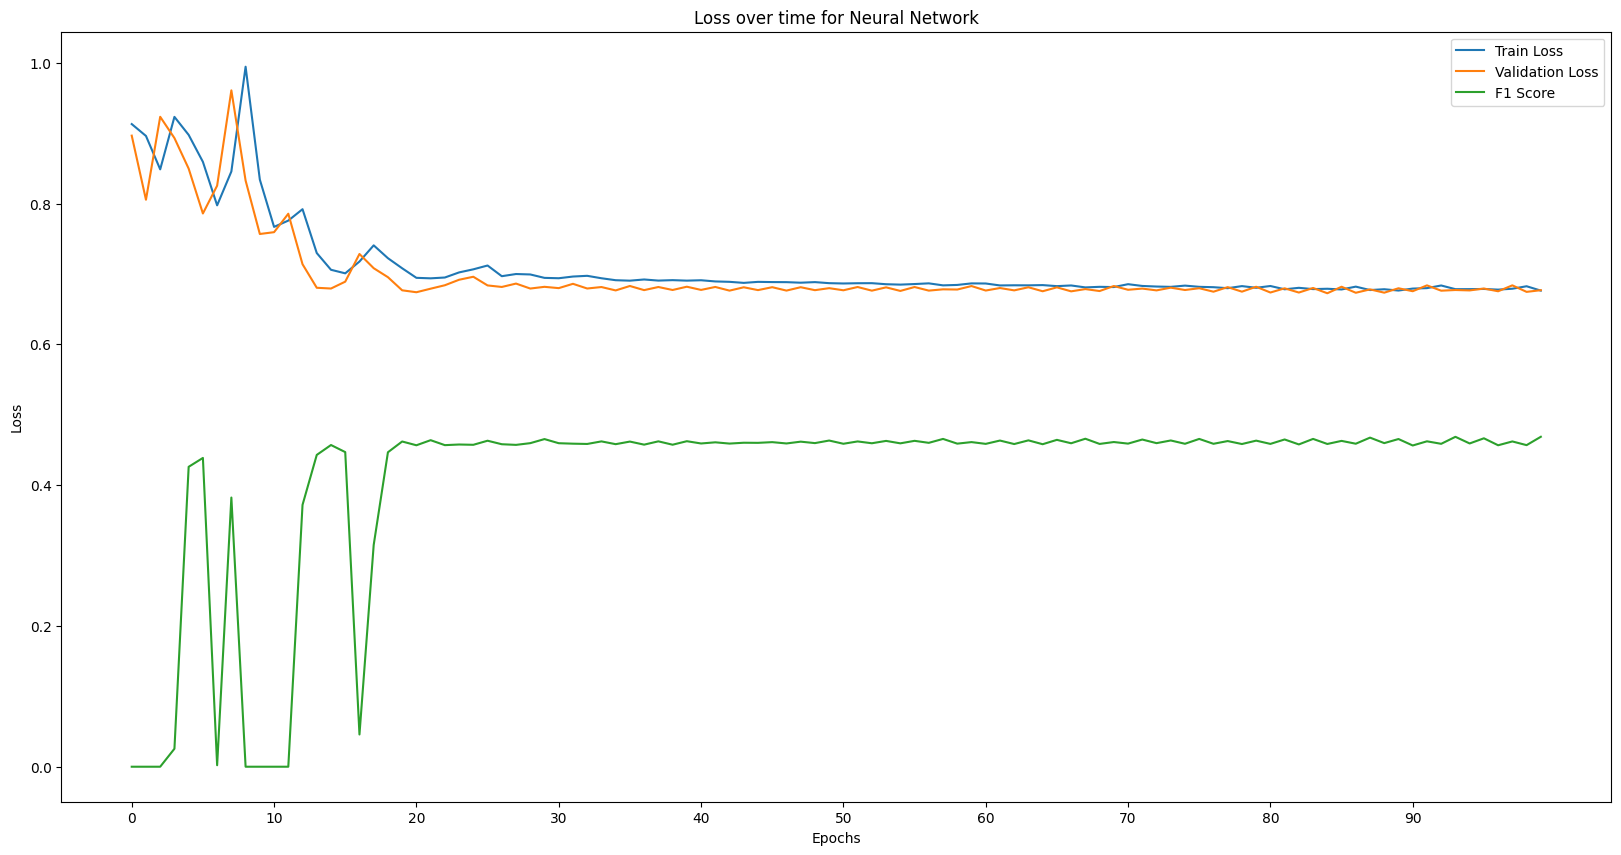

,index,Diabetes_binary
0,219620,0.0
1,132821,0.0
2,151862,0.0
3,139717,0.0
4,239235,1.0
...,...,...
50731,169513,0.0
50732,182415,0.0
50733,109739,0.0
50734,181671,0.0


In [224]:
# Ensure you have access to a GPU if available
print("Is CUDA available?", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_array = []
validation_loss_array = []
F1_score_array = []

class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16)
        ])
        self.output = nn.Linear(16, 1)  # Binary classification output layer
        self.dropout = nn.Dropout(0.1)

        # Xavier uniform initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):  # Ensure it's a linear layer
                nn.init.xavier_uniform_(layer.weight)

        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x))  # Apply ReLU after each linear layer
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)  # Final output layer (no activation here; handled by BCEWithLogitsLoss)
        return x
# TODO to remove
seed = 288
torch.manual_seed(seed)  # Set seed for reproducibility

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1]
model = CustomNN(input_size).to(device)
weights = torch.tensor(2.5, device='cuda:0')
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification # 
optimizer = optim.NAdam(model.parameters(), lr=0.005)


num_epochs = 100  # Increased epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validation_tensor).squeeze()
        val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
        val_preds = torch.round(torch.sigmoid(val_outputs))
                
            # Calculate F1 Score or other metrics
        f1 = f1_score(y_validation_tensor.cpu().numpy(), val_preds.cpu().numpy())    

        # Validation after each epoch
    train_loss_array.append(loss.item())
    validation_loss_array.append(val_loss.item())
    F1_score_array.append(f1)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()},  F1 Score: {f1}")

classification_summary_one(y_validation, val_preds.cpu().numpy())
loss_overtime(train_loss_array, validation_loss_array, F1_score_array, 'Neural Network')
submission_neural_network(model)

### Neural Networks Expiriment with SMOTE

In [225]:
if not isFinal:


    # Ensure you have access to a GPU if available
    print("Is CUDA available?", torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train['Diabetes_binary'])

    # Ensure resampled data is converted to NumPy arrays
    X_train_resampled = np.array(X_train_resampled)
    y_train_resampled = np.array(y_train_resampled)

    # Update tensors for the resampled data
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).to(device)


    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.array([0, 1]), 
        y=y_train_resampled
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    class CustomNN(nn.Module):
        def __init__(self, input_size):
            super(CustomNN, self).__init__()
            self.layers = nn.ModuleList([
                nn.Linear(input_size, 512),
                nn.Linear(512, 512),
                nn.Linear(512, 256),
                nn.Linear(256, 256),
                nn.Linear(256, 128),
                nn.Linear(128, 128),
                nn.Linear(128, 64),
                nn.Linear(64, 64),
                nn.Linear(64, 32),
                nn.Linear(32, 16)
            ])
            self.output = nn.Linear(16, 1)  # Binary classification output layer
            self.dropout = nn.Dropout(0.1)

            # Xavier uniform initialization
            for layer in self.layers:
                if isinstance(layer, nn.Linear):  # Ensure it's a linear layer
                    nn.init.xavier_uniform_(layer.weight)

            nn.init.xavier_uniform_(self.output.weight)

        def forward(self, x):
            for layer in self.layers:
                x = F.leaky_relu(layer(x))  # Apply ReLU after each linear layer
                x = self.dropout(x)  # Apply dropout after activation
            x = self.output(x)  # Final output layer (no activation here; handled by BCEWithLogitsLoss)
            return x

    X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
    y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

    input_size = X_train_tensor.shape[1]
    model = CustomNN(input_size).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
    optimizer = optim.NAdam(model.parameters(), lr=0.005)

    num_epochs = 100  # Increased epochs
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor.squeeze())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation after each epoch
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_validation_tensor).squeeze()
                val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
                val_preds = torch.round(torch.sigmoid(val_outputs))

                # Calculate F1 Score
                f1 = f1_score(y_validation_tensor.cpu().numpy(), val_preds.cpu().numpy())
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}, F1 Score: {f1}")

    classification_summary_one(y_validation, val_preds.cpu().numpy())


In [226]:
if not isFinal:

    # Apply SMOTE on the training data (X_train and y_train)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train['Diabetes_binary'].values)

    # Convert resampled data to PyTorch tensors
    X_train_resampled_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
    y_train_resampled_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).to(device)


    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2, size_average=True):
            super(FocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.size_average = size_average

        def forward(self, inputs, targets):
            # Apply sigmoid to the model's output to get probabilities
            inputs = torch.sigmoid(inputs)
            
            # Calculate cross-entropy
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')

            # Calculate focal loss components
            pt = torch.exp(-BCE_loss)  # pt = probability of correct class
            focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

            # Return the average loss
            if self.size_average:
                return torch.mean(focal_loss)
            else:
                return torch.sum(focal_loss)

    # Use FocalLoss in the training loop:
    focal_loss = FocalLoss(alpha=0.25, gamma=2).to(device)
    # Initialize FocalLoss in place of BCEWithLogitsLoss
    criterion = FocalLoss(alpha=0.25, gamma=2).to(device)

    # Training Loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_resampled_tensor).squeeze()
        loss = criterion(outputs, y_train_resampled_tensor.squeeze())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation after each epoch
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_validation_tensor).squeeze()
                val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
                val_preds = torch.round(torch.sigmoid(val_outputs))

                # Calculate F1 Score or other metrics
                classification_summary_one(y_validation, val_preds)


## Extra

### Difference between Random forest and NN

In [227]:
y_pred = submission_pred(cls_randomforest, X_testing_Scaled)
y_pred_nn = submission_neural_network(model)
y_pred = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': y_pred,
})
# Reset indices to make sure both DataFrames are aligned
y_pred_nn = y_pred_nn.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Now you can compare the predictions without worrying about index misalignment
diff_counter = 0
for index in range(len(y_pred_nn)):
    if y_pred_nn.loc[index, 'Diabetes_binary'] != y_pred.loc[index, 'Diabetes_binary']:
        diff_counter += 1

print('Number of differences:', diff_counter)



Number of differences: 2359


### Predictions of multiple model and neural network

In [228]:
# Validation set predictions
X_testing_Scaled_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)

# Set the model to evaluation mode
model.eval()

# No gradient calculation needed during inference
with torch.no_grad():
    # Get the model's predictions
    predictions = model(X_testing_Scaled_tensor).squeeze()  # Squeeze to remove any extra dimensions

    # Apply sigmoid activation function for binary classification
    predictions = torch.sigmoid(predictions)

    # Convert the probabilities to binary predictions (0 or 1)
    predictions_binary = torch.round(predictions)


# If you want to convert predictions back to a NumPy array for easier use:
predictions_binary = predictions_binary.cpu().numpy()
################################################
pred_array = []
pred_array.append(submission_pred(cls_randomforest, X_validation_scaled))
pred_array.append(submission_pred(cls_logistic, X_validation_scaled))
# pred_array.append(submission_pred(ada_boost, X_validation_scaled))
pred_array.append(predictions_binary)

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

Validation f1 score: 0.4689130128295503

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     17460
           1       0.39      0.59      0.47      2835

    accuracy                           0.81     20295
   macro avg       0.66      0.72      0.68     20295
weighted avg       0.85      0.81      0.83     20295

Validation Set Confusion Matrix:
[[14865  2595]
 [ 1172  1663]]
